In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#problem 1
import matplotlib
from matplotlib import pyplot as plt
import numpy as np

truedata = np.transpose(np.loadtxt('Downloads/dish_zenith.txt'))

def f(x,y,params):
   
    a=params[0]
    x0=params[1]
    y0=params[2]
    z0=params[3]
    
    z = a*x**2-2*a*x*x0+a*x0**2+a*y**2-2*a*y*y0+a*y0**2+z0
    derivs=np.zeros([len(x),len(params)])
    derivs[:,0]=x**2-2*x*x0+x0**2+y**2-2*y*y0+y0**2
    derivs[:,1]=-2*a*x+2*a*x0
    derivs[:,2]=-2*a*y+2*a*y0
    derivs[:,3]=1
    return z,derivs


z_true = truedata[2]
sig=np.std(z_true)
N=np.eye(len(z_true))*sig**2
Ninv=np.eye(len(z_true))/sig**2


pars_guess=np.asarray([10,10,1000,-200])
pars_cur=pars_guess.copy()
for iter in range(10):
    z_pred,derivs=f(truedata[0],truedata[1],pars_cur)
    resid=z_true-z_pred #data minus current model
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
    step=np.linalg.inv(lhs)@rhs
    pars_cur=pars_cur+step
    print('iteration ',iter,' has step ',step)
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)


iteration  0  has step  [-9.99983330e+00 -1.89384407e-04 -1.56998675e-02 -1.16499771e+03]
iteration  1  has step  [ 6.06730378e-14 -1.13602992e+01 -9.41762824e+02 -4.93060755e-03]
iteration  2  has step  [ 2.71050543e-20  4.13475743e-09  3.42761403e-07 -1.47874565e+02]
iteration  3  has step  [ 1.39936333e-19 -5.16330282e-14 -4.95980744e-14 -8.85747888e-13]
iteration  4  has step  [ 4.78271433e-21  7.77999752e-15 -7.11943299e-15  1.65903026e-14]
iteration  5  has step  [ 4.76912241e-21 -3.32266516e-15  5.05357996e-15  1.37133244e-14]
iteration  6  has step  [ 5.13799370e-21  2.27962408e-15 -6.30927984e-15  1.42041012e-14]
iteration  7  has step  [ 4.71231960e-21 -1.15666697e-15  5.89500100e-15  1.41640912e-14]
iteration  8  has step  [ 4.86356970e-21  1.96416521e-16 -5.98773973e-15  1.48723401e-14]
iteration  9  has step  [ 4.71231960e-21 -1.15666697e-15  5.89500100e-15  1.41640912e-14]
final parameters are  [ 1.66704455e-04 -1.36048862e+00  5.82214761e+01 -1.51287721e+03]  with errors

In [4]:
#error in the a through error propagation

z,derivs = f(truedata[0],truedata[1],pars_cur)
noise = np.mean(np.abs(z_true-z))

a=pars_cur[0]
x0=pars_cur[1]
y0=pars_cur[2]
z0=pars_cur[3]
x = truedata[0]
y=truedata[1]

err_a = noise/np.mean(x**2-2*x*x0+x0**2+y**2-2*y*y0+y0**2)

print(err_a)

#no change of parameters to make the problem linear
#no estimation of focal length or its error

6.936569357304065e-07


In [5]:
#problem 2
#Assume installed from github using "git clone --recursive https://github.com/cmbant/CAMB.git"
#This file is then in the docs folders
camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
print('Using CAMB %s installed at %s'%(camb.__version__,os.path.dirname(camb.__file__)))

Using CAMB 1.1.3 installed at /opt/anaconda3/lib/python3.8/site-packages/camb


In [6]:

#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=65, ombh2=0.02, omch2=0.1, tau=0.05)
pars.InitPower.set_params(As=2e-9, ns=0.96, r=0)
pars.set_for_lmax(1150, lens_potential_accuracy=0);

In [7]:
#calculate results for these parameters
results = camb.get_results(pars)

In [8]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
for name in powers: print(name)

total
unlensed_scalar
unlensed_total
lensed_scalar
tensor
lens_potential


In [9]:
wmap = np.transpose(np.loadtxt("Downloads/wmapdata.txt"))

In [10]:
power = np.transpose(powers.get('total'))

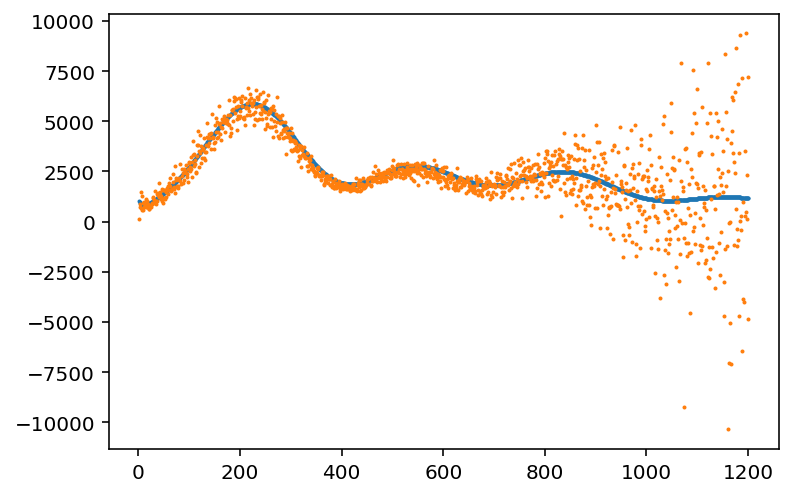

In [11]:
plt.scatter(np.arange(2,1201,1),power[0][2:],s=1)
plt.scatter(np.arange(2,1201,1),wmap[1],s=1)

In [12]:
#inefficient but whatever
chi = 0
for i in range(len(wmap[0])):
    chi = chi + (wmap[1][i]-power[0][i+2])**2/wmap[2][i]**2
    
print(chi)
    

1588.405456955879


In [108]:
#problem 3
#increment each parameter by a certain amount while holding all other parameters constant
#then compute the derivative at every point of the power spectrum
def get_derivs(y_true,pars,step):
    camb1 = camb.CAMBparams()
    camb1.set_cosmology(H0=pars[0], ombh2=pars[1], omch2=pars[2], tau=0.05)
    camb1.InitPower.set_params(As=pars[3], ns=pars[4], r=0)
    camb1.set_for_lmax(1150, lens_potential_accuracy=0);
    results1 = camb.get_results(camb1)
    powers1 = results1.get_cmb_power_spectra(camb1,lmax = 1200, CMB_unit='muK')
    powers_total1 = np.transpose(powers1.get('total'))[0][2:]
    camb2 = camb.CAMBparams()
    derivs = np.zeros([len(step),len(y_true)])
    steps = np.eye(len(step))*step
    for i in range(len(step)):
        camb2.set_cosmology(H0=pars[0]+steps[i][0], ombh2=pars[1]+steps[i][1], omch2=pars[2]+steps[i][2], tau=0.05)
        camb2.InitPower.set_params(As=pars[3]+steps[i][3], ns=pars[4]+steps[i][4], r=0)
        camb2.set_for_lmax(1150, lens_potential_accuracy=0);
        results2 = camb.get_results(camb2)
        powers2 = results2.get_cmb_power_spectra(camb2, lmax = 1200, CMB_unit='muK')
        powers_total2 = np.transpose(powers2.get('total'))[0][2:]
        
        derivs[i]=(powers_total2-powers_total1)/steps[i][i]
        
    return powers_total1, np.transpose(derivs)

In [ ]:
#tried and true Newton's method
#i don't know why the kernel keeps dying
y_true = wmap[1]
sig=wmap[2]
N=np.eye(len(y_true))*sig**2
Ninv=np.eye(len(y_true))/sig**2
pars_guess=np.asarray([65,0.02,0.01,2*10**-9,0.96])
pars_cur=pars_guess.copy()
for iter in range(10):
    steps = pars_cur/10
    y,derivs = get_derivs(y_true,pars_cur,steps)
    resid=y_true-y #data minus current model
    rhs=derivs.T@(Ninv@resid)
    lhs=derivs.T@Ninv@derivs
    step=np.linalg.inv(lhs)@rhs
    pars_cur=pars_cur+step
    print('iteration ',iter,' has step ',step)
par_errs=np.sqrt(np.diag(np.linalg.inv(lhs)))
print('final parameters are ',pars_cur,' with errors ',par_errs)

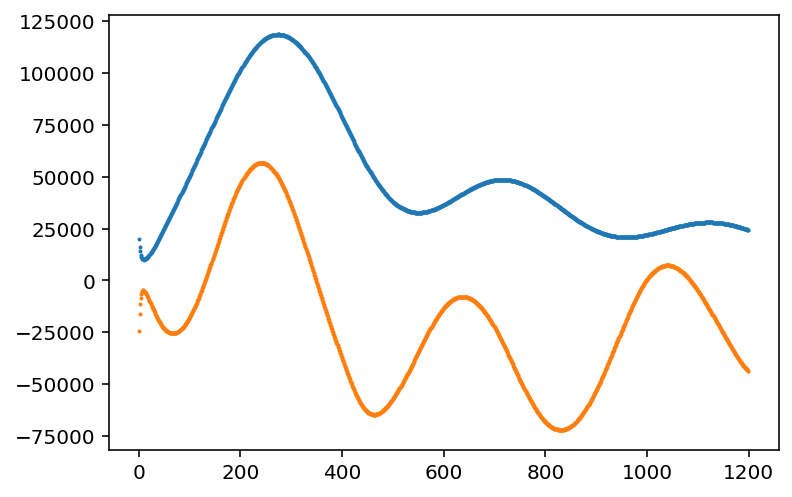

In [111]:
#we can see that for every parameter the derivatives somewhat correspond to what 
#the data is doing
y_true = wmap[1]
pars_guess=np.asarray([65,0.02,0.01,2*10**-9,0.96])
pars=pars_guess.copy()
steps = pars/10
y,derivs = get_derivs(y_true,pars,steps)

camb1 = camb.CAMBparams()
camb1.set_cosmology(H0=pars[0], ombh2=pars[1], omch2=pars[2], tau=0.05)
camb1.InitPower.set_params(As=pars[3], ns=pars[4], r=0)
camb1.set_for_lmax(1150, lens_potential_accuracy=0);
results1 = camb.get_results(camb1)
powers1 = results1.get_cmb_power_spectra(camb1,lmax = 1200, CMB_unit='muK')
powers_total1 = np.transpose(powers1.get('total'))[0][2:]
    
i = 1
plt.scatter(np.arange(1,1200,1),10*powers_total1,s=1)
plt.scatter(np.arange(1,1200,1),np.transpose(derivs)[i],s=1)

In [104]:
#problem 4

def chisq(data,sim,errs):
    chisq = np.sum((sim-data)**2/errs**2)
    return chisq

def mcmc(pars,par_step,chifun,wmap,nstep):
    npar = len(pars)
    chain = np.zeros([nstep,npar])
    chivec = np.zeros(nstep)
    cambobject = camb.CAMBparams()
    cambobject.set_cosmology(H0=pars[0], ombh2=pars[1], omch2=pars[2], tau=pars[3])
    cambobject.InitPower.set_params(As=pars[4], ns=pars[5], r=0)
    cambobject.set_for_lmax(1150, lens_potential_accuracy=0);
    results = camb.get_results(cambobject)
    powers = results.get_cmb_power_spectra(cambobject, CMB_unit='muK')
    powers_total = np.transpose(powers.get('total'))[0][2:]

    chi_cur = chifun(powers_total,wmap[1],wmap[2])
    new = 1
    for i in range(nstep):
        pars_trial = np.zeros(len(pars))
        
        for j in range(len(pars)):
            #get a positive value of tau at every iteration
            rand = np.random.randn(1)*par_step[j]
            if ((j==3) & ((pars[j]+rand)<0)):
                while (pars[j]+rand)<0:
                    rand = np.random.randn(1)*par_step[j]
                pars_trial[j] = pars[j]+rand
            else:
                pars_trial[j] = pars[j]+rand
                
        cambobject.set_cosmology(H0=pars_trial[0], ombh2=pars_trial[1], omch2=pars_trial[2], tau=pars_trial[3])
        cambobject.InitPower.set_params(As=pars_trial[4], ns=pars_trial[5], r=0)
        cambobject.set_for_lmax(1150, lens_potential_accuracy=0);
        results = camb.get_results(cambobject)
        powers = results.get_cmb_power_spectra(cambobject, CMB_unit='muK')
        powers_total = np.transpose(powers.get('total'))[0][2:]
        chi_trial = chifun(powers_total,wmap[1],wmap[2])
        accept_prob = np.exp(-0.5*(chi_trial-chi_cur))
            
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        if i%10==0:
            print("n =",i)
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [16]:
params = np.asarray([65,0.02,0.1,0.05,2*10**-9,0.96])
par_sigs = params/1000
chain,chivec = mcmc(params,par_sigs,chisq,wmap,2000)

n = 0
n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 110
n = 120
n = 130
n = 140
n = 150
n = 160
n = 170
n = 180
n = 190
n = 200
n = 210
n = 220
n = 230
n = 240
n = 250
n = 260
n = 270
n = 280
n = 290
n = 300
n = 310
n = 320
n = 330
n = 340
n = 350
n = 360
n = 370
n = 380
n = 390
n = 400
n = 410
n = 420
n = 430
n = 440
n = 450
n = 460
n = 470
n = 480
n = 490
n = 500
n = 510
n = 520
n = 530
n = 540
n = 550
n = 560
n = 570
n = 580
n = 590
n = 600
n = 610
n = 620
n = 630
n = 640
n = 650
n = 660
n = 670
n = 680
n = 690
n = 700
n = 710
n = 720
n = 730
n = 740
n = 750
n = 760
n = 770
n = 780
n = 790
n = 800
n = 810
n = 820
n = 830
n = 840
n = 850
n = 860
n = 870
n = 880
n = 890
n = 900
n = 910
n = 920
n = 930
n = 940
n = 950
n = 960
n = 970
n = 980
n = 990
n = 1000
n = 1010
n = 1020
n = 1030
n = 1040
n = 1050
n = 1060
n = 1070
n = 1080
n = 1090
n = 1100
n = 1110
n = 1120
n = 1130
n = 1140
n = 1150
n = 1160
n = 1170
n = 1180
n = 1190
n = 1200
n = 1210
n = 1220
n = 

In [21]:
pars_sigs_new = np.std(chain,axis=0)
params_new = params+5*np.random.randn(len(params))*pars_sigs_new
chain2,chivec2 = mcmc(params_new,pars_sigs_new,chisq,wmap,2000)

n = 0
n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 110
n = 120
n = 130
n = 140
n = 150
n = 160
n = 170
n = 180
n = 190
n = 200
n = 210
n = 220
n = 230
n = 240
n = 250
n = 260
n = 270
n = 280
n = 290
n = 300
n = 310
n = 320
n = 330
n = 340
n = 350
n = 360
n = 370
n = 380
n = 390
n = 400
n = 410
n = 420
n = 430
n = 440
n = 450
n = 460
n = 470
n = 480
n = 490
n = 500
n = 510
n = 520
n = 530
n = 540
n = 550
n = 560
n = 570
n = 580
n = 590
n = 600
n = 610
n = 620
n = 630
n = 640
n = 650
n = 660
n = 670
n = 680
n = 690
n = 700
n = 710
n = 720
n = 730
n = 740
n = 750
n = 760
n = 770
n = 780
n = 790
n = 800
n = 810
n = 820
n = 830
n = 840
n = 850
n = 860
n = 870
n = 880
n = 890
n = 900
n = 910
n = 920
n = 930
n = 940
n = 950
n = 960
n = 970
n = 980
n = 990
n = 1000
n = 1010
n = 1020
n = 1030
n = 1040
n = 1050
n = 1060
n = 1070
n = 1080
n = 1090
n = 1100
n = 1110
n = 1120
n = 1130
n = 1140
n = 1150
n = 1160
n = 1170
n = 1180
n = 1190
n = 1200
n = 1210
n = 1220
n = 

In [106]:
pars_sigs_new = np.std(chain,axis=0)
params_new = params+5*np.random.randn(len(params))*pars_sigs_new
chain2a,chivec2a = mcmc(params_new,pars_sigs_new,chisq,wmap,2000)

n = 0
n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 110
n = 120
n = 130
n = 140
n = 150
n = 160
n = 170
n = 180
n = 190
n = 200
n = 210
n = 220
n = 230
n = 240
n = 250
n = 260
n = 270
n = 280
n = 290
n = 300
n = 310
n = 320
n = 330
n = 340
n = 350
n = 360
n = 370
n = 380
n = 390
n = 400
n = 410
n = 420
n = 430
n = 440
n = 450
n = 460
n = 470
n = 480
n = 490
n = 500
n = 510
n = 520
n = 530
n = 540
n = 550
n = 560
n = 570
n = 580
n = 590
n = 600
n = 610
n = 620
n = 630
n = 640
n = 650
n = 660
n = 670
n = 680
n = 690
n = 700
n = 710
n = 720
n = 730
n = 740
n = 750
n = 760
n = 770
n = 780
n = 790
n = 800
n = 810
n = 820
n = 830
n = 840
n = 850
n = 860
n = 870
n = 880
n = 890
n = 900
n = 910
n = 920
n = 930
n = 940
n = 950
n = 960
n = 970
n = 980
n = 990
n = 1000
n = 1010
n = 1020
n = 1030
n = 1040
n = 1050
n = 1060
n = 1070
n = 1080
n = 1090
n = 1100
n = 1110
n = 1120
n = 1130
n = 1140
n = 1150
n = 1160
n = 1170
n = 1180
n = 1190
n = 1200
n = 1210
n = 1220
n = 

In [142]:
#parameter values and their errors after the second "better" chain
#variance in the mean for Gelmin-Rubin
#i know we're supposed to have 5-10 chains but I'm only using two cause of time
#here for completeness
mean_pars = np.mean(chain2,axis=0)
mean_sig = np.std(chain2,axis=0)
mean_var = mean_sig/np.sqrt(len(chain2))
print(mean_pars)
print(mean_sig)
print(mean_var)

[7.12922629e+01 2.26242163e-02 1.09531219e-01 5.24713043e-02
 2.02115003e-09 9.75416667e-01]
[1.91963002e+00 4.40976333e-04 4.30216405e-03 2.31323275e-03
 2.79114822e-11 1.08108900e-02]
[4.29242322e-02 9.86053057e-06 9.61993126e-05 5.17254567e-05
 6.24119716e-13 2.41738849e-04]


In [153]:
#parameter values and their errors after the third chain
mean_pars2 = np.mean(chain2a,axis=0)
mean_sig = np.std(chain2a,axis=0)
mean_var2 = mean_sig/np.sqrt(len(chain2a))
print(mean_pars2)
print(mean_sig)
print(mean_var2)

[7.09039660e+01 2.26494292e-02 1.10577630e-01 6.97363569e-02
 2.10454376e-09 9.76716953e-01]
[2.04571108e+00 5.44272941e-04 4.35313916e-03 9.94102229e-03
 7.00683599e-11 1.30325211e-02]
[4.57434905e-02 1.21703129e-05 9.73391507e-05 2.22288016e-04
 1.56677616e-12 2.91416031e-04]


In [154]:
#compute scatter of means across chains
mean_var_GR = np.zeros([2,len(mean_pars)])
for i in range(len(mean_pars)):
    mean_var_GR[0][i] = ((mean_pars[i]+mean_pars2[i])/2-mean_pars[i])**2
for i in range(len(mean_pars)):
    mean_var_GR[1][i] = ((mean_pars[i]+mean_pars2[i])/2-mean_pars2[i])**2

mean_var_GR = mean_var_GR/np.sqrt(2)

print(mean_var_GR[0])

[2.66534188e-02 1.12375054e-10 1.93566097e-07 5.26939578e-05
 1.22939614e-21 2.98884183e-07]


In [155]:
#this is my attempt at a Gelmin-Rubin test
#graphically, it is pretty obvious that my chains aren't converged.
#in theory, these numbers should be much greater than 1.0e-2
print(mean_var_GR[0]/mean_var)

[6.20941072e-01 1.13964511e-05 2.01213596e-03 1.01872388e+00
 1.96980821e-09 1.23639284e-03]


In [98]:
#problem 5
def mcmc2(pars,par_step,chifun,wmap,nstep):
    npar = len(pars)
    chain = np.zeros([nstep,npar])
    chivec = np.zeros(nstep)
    cambobject = camb.CAMBparams()
    cambobject.set_cosmology(H0=pars[0], ombh2=pars[1], omch2=pars[2], tau=pars[3])
    cambobject.InitPower.set_params(As=pars[4], ns=pars[5], r=0)
    cambobject.set_for_lmax(1150, lens_potential_accuracy=0);
    results = camb.get_results(cambobject)
    powers = results.get_cmb_power_spectra(cambobject, CMB_unit='muK')
    powers_total = np.transpose(powers.get('total'))[0][2:]

    chi_cur = chifun(powers_total,wmap[1],wmap[2])
    new = 1
    for i in range(nstep):
        pars_trial = np.zeros(len(pars))
        
        for j in range(len(pars)):
            #allow tau to float within a certain interval
            rand = np.random.randn(1)*par_step[j]
            if ((j==3) & (((pars[j]+rand)<0.0471) or ((pars[j]+rand)>0.0617))):
                while ((pars[j]+rand)<0.0471) or ((pars[j]+rand)>0.0617):
                    rand = np.random.randn(1)*par_step[j]
                pars_trial[j] = pars[j]+rand
            else:
                pars_trial[j] = pars[j]+rand
                
        cambobject.set_cosmology(H0=pars_trial[0], ombh2=pars_trial[1], omch2=pars_trial[2], tau=pars_trial[3])
        cambobject.InitPower.set_params(As=pars_trial[4], ns=pars_trial[5], r=0)
        cambobject.set_for_lmax(1150, lens_potential_accuracy=0);
        results = camb.get_results(cambobject)
        powers = results.get_cmb_power_spectra(cambobject, CMB_unit='muK')
        powers_total = np.transpose(powers.get('total'))[0][2:]
        chi_trial = chifun(powers_total,wmap[1],wmap[2])
        accept_prob = np.exp(-0.5*(chi_trial-chi_cur))
            
        if np.random.rand(1)<accept_prob: #accept the step with appropriate probability
            pars=pars_trial
            chi_cur=chi_trial
        if i%10==0:
            print("n =",i)
        chain[i,:]=pars
        chivec[i]=chi_cur
    return chain,chivec

In [103]:
params = np.asarray([65,0.02,0.1,0.0544,2*10**-9,0.96])
par_sigs = params/1000
chain3,chivec3 = mcmc2(params,par_sigs,chisq,wmap,2000)

n = 0
n = 10
n = 20
n = 30
n = 40
n = 50
n = 60
n = 70
n = 80
n = 90
n = 100
n = 110
n = 120
n = 130
n = 140
n = 150
n = 160
n = 170
n = 180
n = 190
n = 200
n = 210
n = 220
n = 230
n = 240
n = 250
n = 260
n = 270
n = 280
n = 290
n = 300
n = 310
n = 320
n = 330
n = 340
n = 350
n = 360
n = 370
n = 380
n = 390
n = 400
n = 410
n = 420
n = 430
n = 440
n = 450
n = 460
n = 470
n = 480
n = 490
n = 500
n = 510
n = 520
n = 530
n = 540
n = 550
n = 560
n = 570
n = 580
n = 590
n = 600
n = 610
n = 620
n = 630
n = 640
n = 650
n = 660
n = 670
n = 680
n = 690
n = 700
n = 710
n = 720
n = 730
n = 740
n = 750
n = 760
n = 770
n = 780
n = 790
n = 800
n = 810
n = 820
n = 830
n = 840
n = 850
n = 860
n = 870
n = 880
n = 890
n = 900
n = 910
n = 920
n = 930
n = 940
n = 950
n = 960
n = 970
n = 980
n = 990
n = 1000
n = 1010
n = 1020
n = 1030
n = 1040
n = 1050
n = 1060
n = 1070
n = 1080
n = 1090
n = 1100
n = 1110
n = 1120
n = 1130
n = 1140
n = 1150
n = 1160
n = 1170
n = 1180
n = 1190
n = 1200
n = 1210
n = 1220
n = 

In [147]:
#parameter values and their errors after the Tau-stabilized chain
mean_pars3 = np.mean(chain3,axis=0)
mean_sig3 = np.std(chain3,axis=0)
print(mean_pars3)
print(mean_sig3)

[6.92972571e+01 2.09990763e-02 1.04924837e-01 5.38189963e-02
 1.96171506e-09 9.51367213e-01]
[1.37836751e+00 5.83013421e-04 1.58975599e-03 7.25380105e-04
 1.35763956e-11 7.83498174e-03]


In [156]:
#compared to values in the second chain
print(mean_pars)
print(mean_pars3)

#no importance sampling

[7.12922629e+01 2.26242163e-02 1.09531219e-01 5.24713043e-02
 2.02115003e-09 9.75416667e-01]
[6.92972571e+01 2.09990763e-02 1.04924837e-01 5.38189963e-02
 1.96171506e-09 9.51367213e-01]


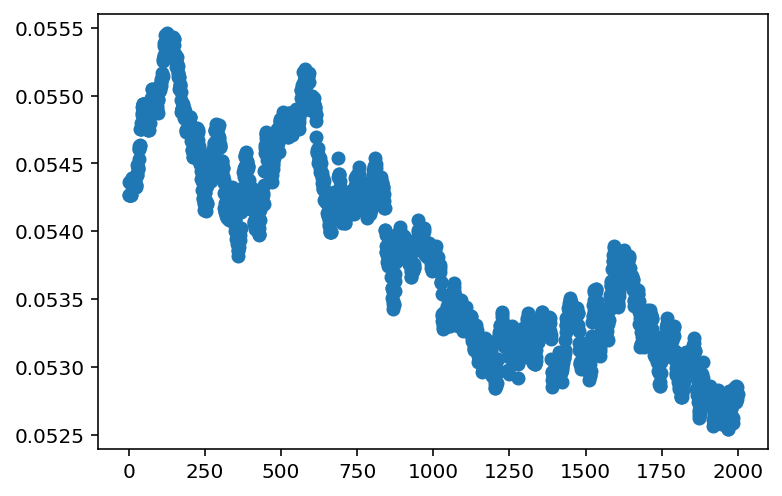

In [152]:
plt.scatter(np.arange(0,2000,1),np.transpose(chain3)[3])

In [151]:
len(np.arange(0,2000,1))

2000